In [1]:
import faiss
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
def get_random_normalized_vectors(n, m):
    x = np.random.uniform(-1.0, 1.0, (n, m))
    x += np.random.binomial(1, 0.1, (n, m)) * np.random.uniform(-5.0, 5.0, (n, m))
    x = (x.T / np.sqrt(np.sum(x*x, axis=1))).T
    return x.astype(np.float32)

n_dim = 128
nb = 1000000
nq = 1000
topk = 1000

xb = get_random_normalized_vectors(nb, n_dim)
xq = get_random_normalized_vectors(nq, n_dim)

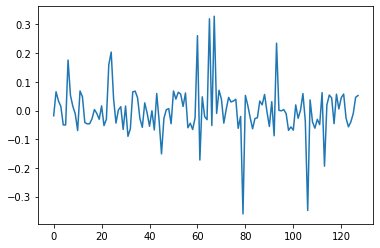

In [3]:
plt.plot(xb[0])

In [4]:
idxs_true = np.argsort(-np.dot(xq, xb.T), axis=1)[:,:topk]

In [5]:
def evaluate(idxs_pred, idxs_true):
    assert idxs_pred.shape == idxs_true.shape
    topk = idxs_pred.shape[1]
    scores = []
    for a, b in zip(idxs_pred, idxs_true):
        score = len(set(a)&set(b)) / topk
        scores.append(score)
    return np.mean(scores)

## Exhaustive search

In [6]:
%%time
index = faiss.index_factory(n_dim, "Flat", faiss.METRIC_INNER_PRODUCT)
index.add(xb)

CPU times: user 75.8 ms, sys: 252 ms, total: 327 ms
Wall time: 504 ms


In [7]:
%%time
distance, idxs = index.search(xq, topk)

CPU times: user 14.2 s, sys: 2.45 s, total: 16.7 s
Wall time: 2.65 s


In [8]:
evaluate(idxs, idxs_true)

1.0

## Non-exhaustive search

In [9]:
%%time
index = faiss.index_factory(n_dim, "IVF100,Flat", faiss.METRIC_INNER_PRODUCT)
index.train(xb)
index.add(xb)

CPU times: user 2.83 s, sys: 897 ms, total: 3.73 s
Wall time: 615 ms


In [10]:
%%time
index.nprobe = 10
distance, idxs = index.search(xq, topk)

CPU times: user 6.25 s, sys: 95.7 ms, total: 6.35 s
Wall time: 929 ms


In [11]:
evaluate(idxs, idxs_true)

0.495274